Импортируем библиотеки

In [145]:
import math
import requests
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf

Введём вспомогательные функции

In [92]:
def LoopPrecentage(start,end,current_value):
    fin=end-start
    print(f"CURRENT PROGRESS IS APPROXIMATELY {(current_value-start)*100/fin}%")
for i in range(3,7,2):
    print(i)

3
5


Загрузим котировки, между датами обязательно должна быть разница минимум в сутки

In [199]:
url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCRUB'
interval = '1h'#CONSTANT AFFECTS LOOP
limit = 1000
start = int(dt.datetime(2022,1,1).timestamp()*1000)
end = int(dt.datetime(2023,3,1).timestamp()*1000)
print(f"START TIME {start} AND END TIME {end} AND DIFFERENCE BETWEEN THEM IS {end-start}")

maxlimit = 0
points = (end-start)/(1000*3600)
if limit >= points:
    step = end-start
    limit = math.ceil(points)
    maxlimit = limit
else:
    maxlimit = math.ceil(points)
    times=math.ceil(maxlimit/limit)
    print(f"AMOUNT OF TIMES TO LOAD {times}")
    step = int((end-start)/(times))    
print(f"STEP IS {step}") 

data = pd.DataFrame(columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'])

for i in range(start,end,step):
    LoopPrecentage(start,end,i)
    limit = int(maxlimit/times)
    par = {'symbol': symbol, 'interval': interval,'limit':limit, 'startTime': str(i), 'endTime': str(i+step)}
    print(par)
    new_data = pd.DataFrame(json.loads(requests.get(url, params= par).text))
    new_data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
    if len(data) == 0:
        data = new_data
    else:
        data = pd.concat([data,new_data])
    print(len(data))
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
data=data.astype(float)

START TIME 1640984400000 AND END TIME 1677618000000 AND DIFFERENCE BETWEEN THEM IS 36633600000
AMOUNT OF TIMES TO LOAD 11
STEP IS 3330327272
CURRENT PROGRESS IS APPROXIMATELY 0.0%
{'symbol': 'BTCRUB', 'interval': '1h', 'limit': 925, 'startTime': '1640984400000', 'endTime': '1644314727272'}
925
CURRENT PROGRESS IS APPROXIMATELY 9.09090908892383%
{'symbol': 'BTCRUB', 'interval': '1h', 'limit': 925, 'startTime': '1644314727272', 'endTime': '1647645054544'}
1850
CURRENT PROGRESS IS APPROXIMATELY 18.18181817784766%
{'symbol': 'BTCRUB', 'interval': '1h', 'limit': 925, 'startTime': '1647645054544', 'endTime': '1650975381816'}
2775
CURRENT PROGRESS IS APPROXIMATELY 27.27272726677149%
{'symbol': 'BTCRUB', 'interval': '1h', 'limit': 925, 'startTime': '1650975381816', 'endTime': '1654305709088'}
3700
CURRENT PROGRESS IS APPROXIMATELY 36.36363635569532%
{'symbol': 'BTCRUB', 'interval': '1h', 'limit': 925, 'startTime': '1654305709088', 'endTime': '1657636036360'}
4625
CURRENT PROGRESS IS APPROXIMAT

Сохраним в виде csv файла

In [153]:
data.to_csv(f"{symbol}{interval}{start}{end}")

Визуализируем корреляционную матрицу

<AxesSubplot: >

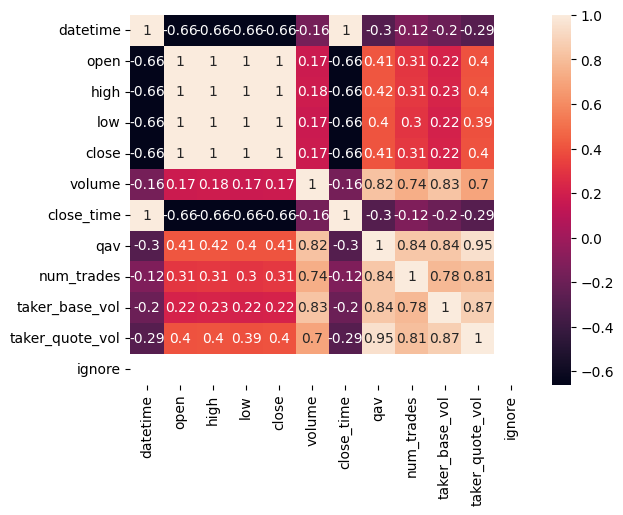

In [193]:
corr_matrix = data.corr()
sn.heatmap(corr_matrix,annot=True)

Избавимся от всех колонок (раньше от сильно коррелирующих только, но другие признаки неизвестны, хоть и их можно в теории предсказывать с помощью других нейросетей, но сейчас мы опираемся только на время)

In [200]:
data=data.drop(["open","high","low","volume","close_time","qav","num_trades","taker_base_vol","taker_quote_vol","ignore"],axis=1)

Нормализиуем дату просто и разделим выборку на тренировочную и тестовую

In [201]:
def NormalizeDataFrame(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for i in df.columns:
        df[i]=min_max_scaler.fit_transform(df[i].values.reshape(-1,1))

NormalizeDataFrame(data)
random_state = 0
train_size = 0.8

x_train, x_test, y_train, y_test = train_test_split(data.drop(["close"],axis=1),
                                                    data.close,
                                                    train_size=train_size,
                                                    random_state=random_state,
                                                   shuffle=True)

Посмотрим на получившееся датасеты

In [202]:
print(x_train.head())
print(y_train.head())

                     datetime
2022-05-14 01:00:00  0.287632
2022-08-14 23:00:00  0.488515
2022-04-06 01:00:00  0.205477
2022-05-20 06:00:00  0.301054
2022-06-20 06:00:00  0.368075
2022-05-14 01:00:00    0.234996
2022-08-14 23:00:00    0.131495
2022-04-06 01:00:00    0.705902
2022-05-20 06:00:00    0.216233
2022-06-20 06:00:00    0.049414
Name: close, dtype: float64


Создадим простую нейросеть

In [203]:
input_dim = 1  # Размерность входных данных (одномерный временной ряд)
learning_rate=0.005

RNN = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(input_dim,1)),
    tf.keras.layers.Dense(1)
])
RNN.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # normal rate =0.001
  loss="mse",
)
epochs = 200
validation_split = 0.3
RNN.fit(
  x=x_train,
  y=y_train,
  validation_split=validation_split,
  epochs=epochs,
  batch_size=32,
  #callbacks=[tf.keras.callbacks.TensorBoard(os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))]
    )

Epoch 1/200
195/195 [==============================] - 3s 5ms/step - loss: 0.0379 - val_loss: 0.0241
Epoch 2/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0175
Epoch 3/200
195/195 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 4/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 5/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 6/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 7/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 8/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 9/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 10/200
195/195 [==============================] - 0s 3ms/step - loss: 0.0140 - val_lo

195/195 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 82/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 83/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 84/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 85/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 86/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 87/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 88/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 89/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 90/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 

Epoch 161/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 162/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 163/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 164/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 165/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 166/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 167/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 168/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 169/200
195/195 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 170/200
195/195 [==============================] - 1s 3ms/step - lo

Визуализируем её предсказания и сравним её реальными значениями

                     datetime     close
2023-04-08 13:00:00       1.0  0.314066
347/347 [==============================] - 1s 2ms/step


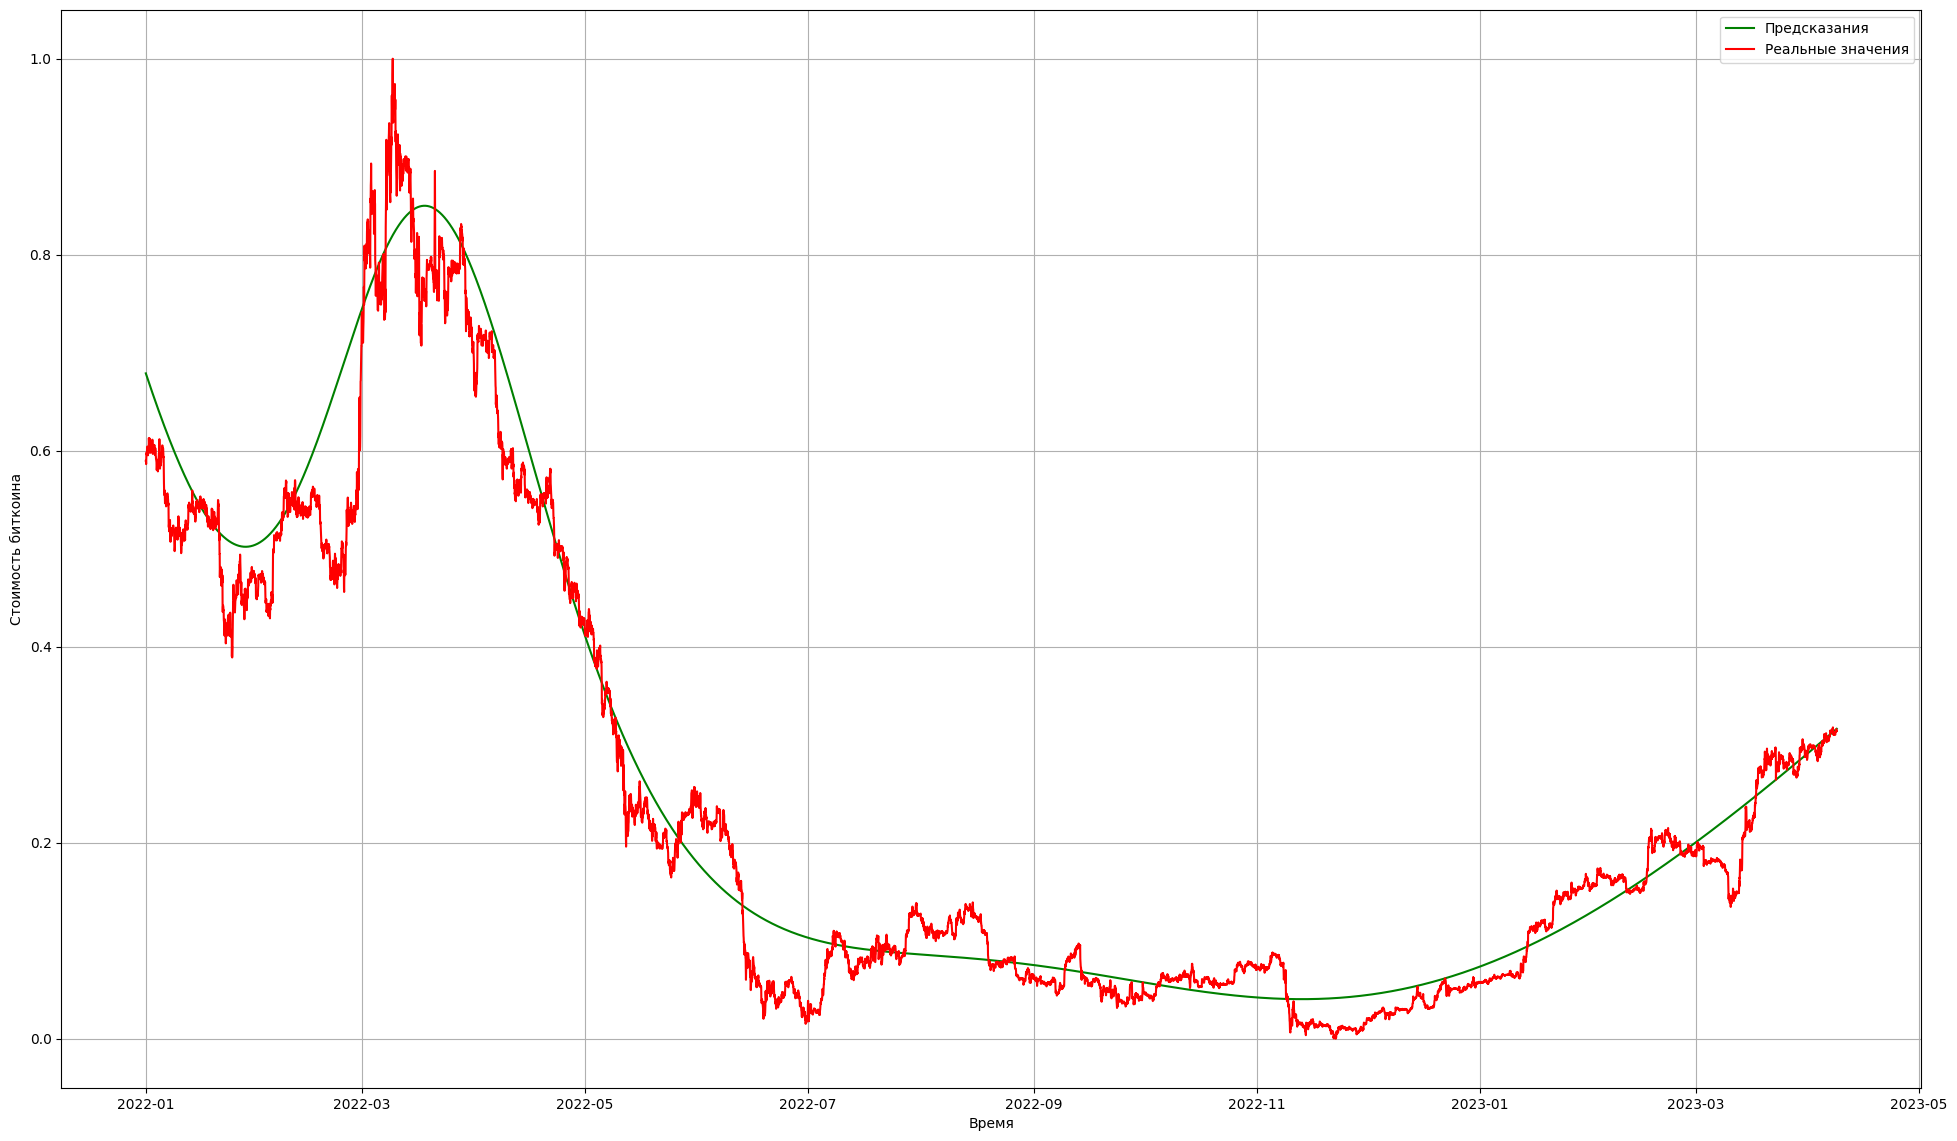

In [208]:
series=data.iloc[-1:]
print(series)
fig, ax = plt.subplots()
ax.plot(data.index,RNN.predict(data.drop(["close"],axis=1)),"g",
        data.index,data.close,"r",
       )
ax.grid()
ax.set_xlabel("Время")
ax.set_ylabel("Стоимость биткоина")
ax.legend(("Предсказания",
            "Реальные значения"))
fig.set_size_inches(24,14)

Посчитаем потери по MSE на тестовой выборке

In [209]:
print(f"EVALUATE ON TEST DATA MSE LOSS IS{RNN.evaluate(x_test,y_test)}")

70/70 [==============================] - 0s 2ms/step - loss: 0.0022
EVALUATE ON TEST DATA 0.0021949077490717173


Особенности:
    1)Хотел прислать так быстро, как возможно, поэтому не разобрался как предсказывать будующее. Мне понятно что данные нужно нормализировать, иначе нейросеть даже на той выборке, на которой тренируется не в состоянии что-то предсказать. Но как нормализовать или обрабатывать новые данные мне не совсем ясно. 